# COMP 551 - Mini-project 4
Group 62

In [ ]:
import keras
import numpy as np
from sklearn import datasets
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import pandas as pd
import seaborn as sns
import os
import pylab

np.random.seed(1234)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/'
pathfig='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/figures'

Mounted at /content/drive


## MNIST Dataset

In [ ]:
# Provided by the author
X_author = np.loadtxt(path+"mnist2500_X.txt")
labels_author = np.loadtxt(path+"mnist2500_labels.txt")
print(X_author.shape, labels_author.shape)
print(X_author[:3,100:110])
print('Intensity range:', np.amin(X_author), np.amax(X_author))
print(labels_author[:10])

(2500, 784) (2500,)
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Intensity range: 0.0 1.0
[5. 0. 4. 1. 9. 2. 1. 3. 1. 4.]


In [ ]:
# from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

# vectorize
x_train = np.reshape(x_train, (-1, 784)).astype('float32')
print(x_train.shape)

# normalize
print('Intensity before normalization:', np.amin(x_train), np.amax(x_train))
x_train = x_train/255.0
print('Intensity after normalization:', np.amin(x_train), np.amax(x_train))

# subset 6000 instances
data_slice = 6000
X = x_train[:data_slice,:]
labels = y_train[:data_slice]
print(X.shape, labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(60000, 784)
Intensity before normalization: 0.0 255.0
Intensity after normalization: 0.0 1.0
(6000, 784) (6000,)


## Code from the author

In [ ]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 50:
            P = P / 4.

    # Return solution
    return Y

## t-SNE 

In [ ]:
%%time
Y = tsne(X, 2, initial_dims=30, perplexity=40.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 6000...
Computing P-values for point 500 of 6000...
Computing P-values for point 1000 of 6000...
Computing P-values for point 1500 of 6000...
Computing P-values for point 2000 of 6000...
Computing P-values for point 2500 of 6000...
Computing P-values for point 3000 of 6000...
Computing P-values for point 3500 of 6000...
Computing P-values for point 4000 of 6000...
Computing P-values for point 4500 of 6000...
Computing P-values for point 5000 of 6000...
Computing P-values for point 5500 of 6000...
Mean value of sigma: 1.883204
Iteration 10: error is 24.810768
Iteration 20: error is 24.125473
Iteration 30: error is 22.166950
Iteration 40: error is 20.748020
Iteration 50: error is 19.835543
Iteration 60: error is 3.140650
Iteration 70: error is 2.837965
Iteration 80: error is 2.636951
Iteration 90: error is 2.488638
Iteration 100: error is 2.372310
Iteration 110: error is 2.277771
Iterati

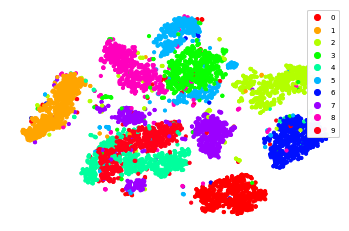

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'tSNE6000.png'))
plt.show()

## Other methods

### Isomap

Preprocessing the data using PCA...


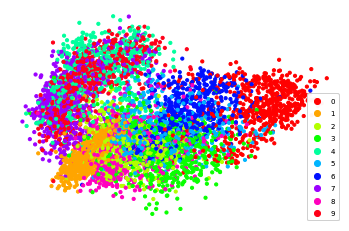

CPU times: user 37 s, sys: 1.89 s, total: 38.9 s
Wall time: 36.9 s


In [ ]:
%%time 
from sklearn.manifold import Isomap
embedding = Isomap(n_neighbors=12, n_components=2)
X_reduced = pca(X, no_dims=30).real
Y = embedding.fit_transform(X_reduced)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'Isomap6000.png'))
plt.show()

### LLE

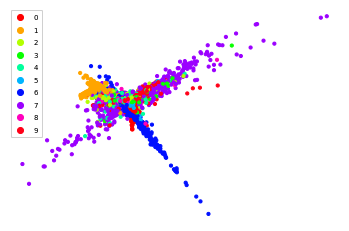

CPU times: user 21 s, sys: 10.1 s, total: 31.1 s
Wall time: 17.1 s


In [ ]:
%%time 
from sklearn.manifold import LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_neighbors=12, n_components=2)
Y = embedding.fit_transform(X_reduced)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'LLE6000.png'))
plt.show()

### Sammon mapping

Implementation by Tom Pollard https://github.com/tompollard/sammon/blob/master/sammon.py

In [ ]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

epoch = 1 : E = 0.2371866895
epoch = 2 : E = 0.2368529299
epoch = 3 : E = 0.2351082328
epoch = 4 : E = 0.2314944634
epoch = 5 : E = 0.2273707171
epoch = 6 : E = 0.2265654408
epoch = 7 : E = 0.2262693604
epoch = 8 : E = 0.2193380034
epoch = 9 : E = 0.2190422366
epoch = 10 : E = 0.2163218919
epoch = 11 : E = 0.2160046692
epoch = 12 : E = 0.2159431865
epoch = 13 : E = 0.2071065703
epoch = 14 : E = 0.2057243375
epoch = 15 : E = 0.2048355523
epoch = 16 : E = 0.2030901531
epoch = 17 : E = 0.2016263630
epoch = 18 : E = 0.2009476939
epoch = 19 : E = 0.2009194407
epoch = 20 : E = 0.1962227064
epoch = 21 : E = 0.1960533096
epoch = 22 : E = 0.1920750789
epoch = 23 : E = 0.1917732548
epoch = 24 : E = 0.1906458629
epoch = 25 : E = 0.1861745816
epoch = 26 : E = 0.1845520614
epoch = 27 : E = 0.1817518982
epoch = 28 : E = 0.1817359140
epoch = 29 : E = 0.1794623894
epoch = 30 : E = 0.1787942372
epoch = 31 : E = 0.1771106191
epoch = 32 : E = 0.1768466158
epoch = 33 : E = 0.1765978764
epoch = 34 : E = 0.

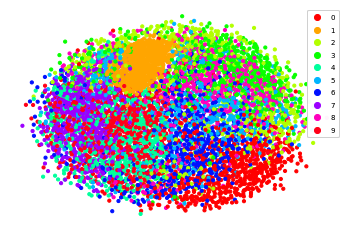

CPU times: user 1h 19min 30s, sys: 3min 15s, total: 1h 22min 45s
Wall time: 1h 14min 50s


In [ ]:
%%time
[Y, E] = sammon(X, 2, maxiter = 1000)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'Sammon6000.png'))
plt.show()